In [3]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
!pip install tensorflow-addons
import tensorflow_addons as tfa
from sklearn.model_selection import train_test_split

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [4]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [5]:
!git clone https://github.com/naufalhisyam/TurbidityPrediction-thesis.git
os.chdir('/content/TurbidityPrediction-thesis') 

Cloning into 'TurbidityPrediction-thesis'...
remote: Enumerating objects: 2975, done.
remote: Counting objects: 100% (955/955), done.
remote: Compressing objects: 100% (942/942), done.
remote: Total 2975 (delta 15), reused 952 (delta 13), pack-reused 2020
Receiving objects: 100% (2975/2975), 670.42 MiB | 23.34 MiB/s, done.
Resolving deltas: 100% (110/110), done.
Checking out files: 100% (2324/2324), done.


LOAD MODEL

In [ ]:
model_path = r'/content/gdrive/MyDrive/MODEL BERHASIL/0deg/ResNet_0deg_imagenet_lr1e-4_decay1e-6_bs8_huber/resnet-epoch100-loss2.519927978515625'
name = 'ResNet50_0deg_TL'

if not os.path.exists(f'plots/{name}'):
  os.makedirs(f'plots/{name}')

model = tf.keras.models.load_model(model_path) #loads saved model

In [6]:
images = pd.read_csv(r'./Datasets/0degree/0degInfo.csv') #load dataset info
train_df, test_df = train_test_split(images, train_size=0.9, shuffle=True, random_state=1) #Split into train and test set

train_generator = tf.keras.preprocessing.image.ImageDataGenerator(
    horizontal_flip=True
)

test_generator = tf.keras.preprocessing.image.ImageDataGenerator(
    horizontal_flip=True
)

In [7]:
train_images = train_generator.flow_from_dataframe(
    dataframe=train_df,
    x_col='Filepath',
    y_col='Turbidity',
    target_size=(224, 224),
    color_mode='rgb',
    class_mode='raw',
    batch_size=32,
    shuffle=False,
    seed=42,
)

test_images = test_generator.flow_from_dataframe(
    dataframe=test_df,
    x_col='Filepath',
    y_col='Turbidity',
    target_size=(224, 224),
    color_mode='rgb',
    class_mode='raw',
    batch_size=32,
    shuffle=False
)

Found 555 validated image filenames.
Found 138 validated image filenames.
Found 78 validated image filenames.


**Plotting Model Graphs**

In [62]:
test_pred = np.squeeze(model.predict(test_images))
test_true = test_images.labels
test_residuals = test_true - test_pred

train_pred = np.squeeze(model.predict(train_images))
train_true = train_images.labels
train_residuals = trrain_true - train_pred

train_score = model.evaluate(train_images)
test_score = model.evaluate(test_images)
print(test_score)
print(train_score)

3/3 [==============================] - 15s 3s/step - loss: 2.4490 - mae: 2.8859 - mse: 15.1904 - R2: 0.9956
[2.448970317840576, 2.8859448432922363, 15.190370559692383, 0.9956034421920776]


Residual Plot

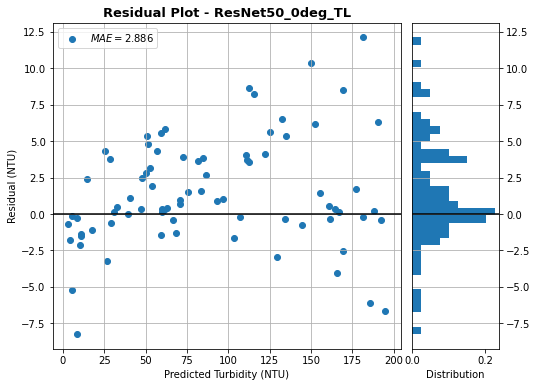

In [71]:
f, axs = plt.subplots(1, 2, figsize=(8,6), gridspec_kw={'width_ratios': [4, 1]})
fig.suptitle(f'Residual Plot - {name}', fontsize=13, fontweight='bold') 

axs[0].scatter(test_pred,test_residuals, label=f'$Test Set')
axs[0].scatter(train_pred,train_residuals, label=f'$Train Set')        
axs[0].set_ylabel('Residual (NTU)')
axs[0].set_xlabel('Predicted Turbidity (NTU)')      
axs[0].axhline(0, color='black')
axs[0].legend()
axs[0].grid()

axs[1].hist(test_residuals, bins=40, orientation="horizontal", density=True)
axs[1].hist(train_residuals, bins=40, orientation="horizontal", density=True)
axs[1].axhline(0, color='black')
axs[1].set_xlabel('Distribution')  
axs[1].yaxis.tick_right()
axs[1].grid(axis='y')

plt.subplots_adjust(wspace=0.05)

plt.savefig(f'plots/{name}/residualPlot_{name}.png', dpi=150)
plt.show()

Measured vs Predicted Plot

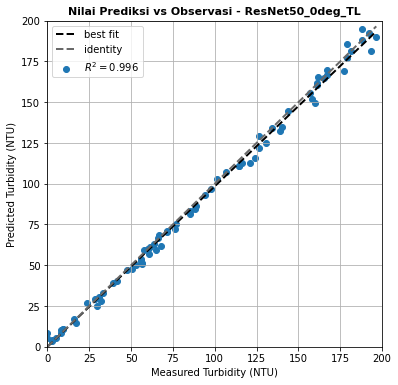

In [88]:
fig, ax = plt.subplots(1,2,figsize=(13,6))
fig.suptitle(f'Nilai Prediksi vs Observasi - {name}', fontsize=11, fontweight='bold')

ax[0].scatter(test_true,test_pred, label=f'$Test R^2=${round(test_score[3],3)}')
theta = np.polyfit(test_true, test_pred, 1)
y_line = theta[1] + theta[0] * test_true
ax[0].plot([test_true.min(), test_true.max()], [y_line.min(), y_line.max()],'k--', lw=2,label='best fit')
ax[0].plot([test_true.min(), test_true.max()], [test_true.min(), test_true.max()], 'k--', lw=2, label='identity',color='dimgray')
ax[0].set_xlabel('Measured Turbidity (NTU)')
ax[0].set_ylabel('Predicted Turbidity (NTU)')
ax[0].set_title(f'Test Set', fontsize=10, fontweight='bold')
ax[0].set_xlim([0, 200])
ax[0].set_ylim([0, 200])
ax[0].grid()
ax[0].legend()

ax[1].scatter(train_true,train_pred, label=f'$Train R^2=${round(train_score[3],3)}', color='tab:orange')
theta2 = np.polyfit(train_true, train_pred, 1)
y_line2 = theta2[1] + theta2[0] * train_true
ax[1].plot([train_true.min(), train_true.max()], [y_line2.min(), y_line2.max()],'k--', lw=2,label='best fit')
ax[1].plot([train_true.min(), train_true.max()], [train_true.min(),train_true.max()], 'k--', lw=2, label='identity',color='dimgray')
ax[1].set_xlabel('Measured Turbidity (NTU)')
ax[1].set_ylabel('Predicted Turbidity (NTU)')
ax[1].set_title(f'Train Set', fontsize=10, fontweight='bold')
ax[1].set_xlim([0, 200])
ax[1].set_ylim([0, 200])
ax[1].grid()
ax[1].legend()

plt.savefig(f'plots/{name}/predErrorPlot_{name}.png', dpi=150)
plt.show()

Training History

In [59]:
history = pd.read_csv(f'{model_path}/history.csv')

loss = history['loss']
val_loss = history['val_loss']
ma_error = history['mae']
val_ma_error = history['val_mae']
r2 = history['R2']
val_r2 = history['val_R2']
ms_error = history['mse']
val_ms_error = history['val_mse']

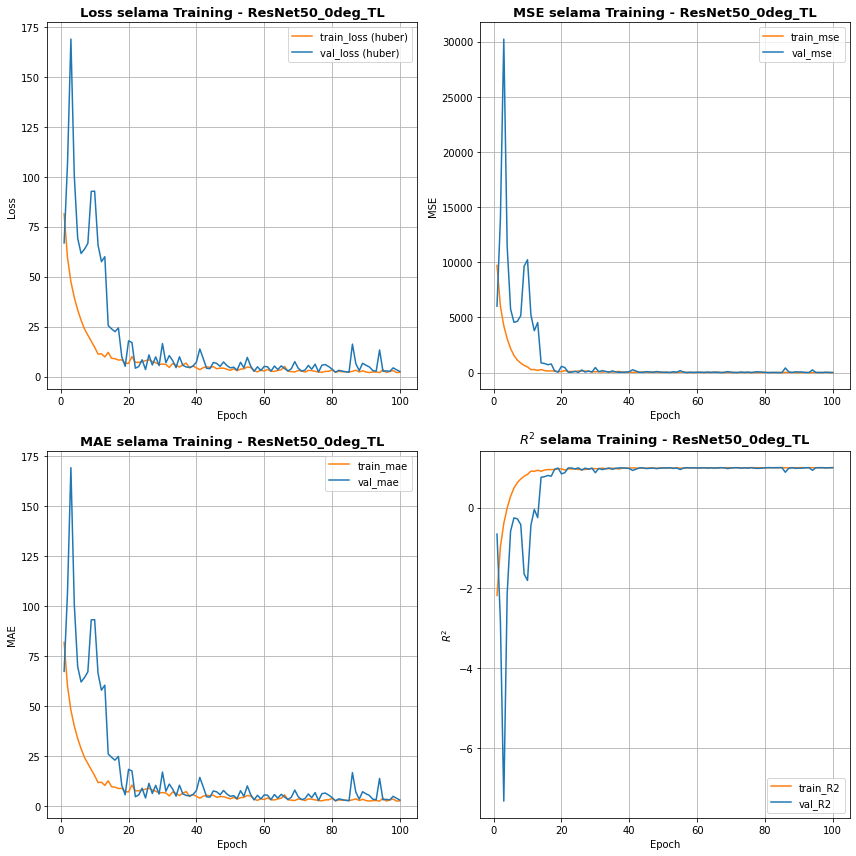

In [60]:
epochs = range(1, len(loss) + 1)

f, axs = plt.subplots(2, 2, figsize=(12,12))
f.suptitle(f'Grafik Training - {name}', fontsize=13, fontweight='bold')
axs[0][0].plot(epochs, loss, 'tab:green', label='train_loss (huber)')
axs[0][0].plot(epochs, val_loss, 'tab:red', label='val_loss (huber)')
axs[0][0].set_title('Loss selama Training', fontsize=10, fontweight='bold')
axs[0][0].set_xlabel('Epoch')
axs[0][0].set_ylabel('Loss')
axs[0][0].legend(facecolor='white')
axs[0][0].grid()

axs[0][1].plot(epochs, ms_error, 'tab:green', label='train_mse')
axs[0][1].plot(epochs, val_ms_error, 'tab:red', label='val_mse')
axs[0][1].set_title('MSE selama Training ', fontsize=10, fontweight='bold')
axs[0][1].set_xlabel('Epoch')
axs[0][1].set_ylabel('MSE')
axs[0][1].legend(facecolor='white')
axs[0][1].grid()

axs[1][0].plot(epochs, ma_error, 'tab:green', label='train_mae')
axs[1][0].plot(epochs, val_ma_error, 'tab:red', label='val_mae')
axs[1][0].set_title('MAE selama Training', fontsize=10, fontweight='bold')
axs[1][0].set_xlabel('Epoch')
axs[1][0].set_ylabel('MAE')
axs[1][0].legend(facecolor='white')
axs[1][0].grid()

axs[1][1].plot(epochs, r2, 'tab:green', label='train_R2')
axs[1][1].plot(epochs, val_r2, 'tab:red', label='val_R2')
axs[1][1].set_title('$\textbf{R^2}$ selama Training', fontsize=10, fontweight='bold')
axs[1][1].set_xlabel('Epoch')
axs[1][1].set_ylabel('$\textbf{R^2}$')
axs[1][1].legend(facecolor='white')
axs[1][1].grid()

plt.tight_layout()
plt.savefig(f'plots/{name}/trainPlot_{name}.png', dpi=150)
plt.show()

In [61]:
save_path = f"/content/gdrive/MyDrive/MODEL BERHASIL/Plots"
if not os.path.exists(save_path):
  os.makedirs(save_path)

oripath = "plots/."
!cp -a "{oripath}" "{save_path}" # copies files to google drive
print("Done!")